In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
from PIL import Image
import os
import string
from pickle import dump
from pickle import load
from keras.applications.xception import Xception
from keras.applications.xception import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import add
from keras.layers import Concatenate
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.layers import LSTM, Embedding, Dropout
from tqdm import tqdm_notebook as tqdm
import h5py
tqdm().pandas()

<ipython-input-2-6a85ba29dd66>:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  tqdm().pandas()


0it [00:00, ?it/s]

In [ ]:
def load_fp(filename):
  file = open(filename, 'r')
  text = file.read()
  file.close()
  return text

In [ ]:
def load_doc(filename):
    try:
        with open(filename, 'r') as file:
            text = file.read()
        return text
    except FileNotFoundError:
        print(f"Error: File '{filename}' not found.")
        return None

In [ ]:
try:
  def all_img_captions(filename):
      file = load_doc(filename)
      captions = file.split('\n')
      descriptions ={}
      for caption in captions[:-1]:
          img, caption = caption.split('\t')
          if img[:-2] not in descriptions:
              descriptions[img[:-2]] = [ caption ]
          else:
              descriptions[img[:-2]].append(caption)
      return descriptions
except Exception as e:
  print("Error:", e)

In [ ]:
def cleaning_text(captions):
    table = str.maketrans('','',string.punctuation)
    for img,caps in captions.items():
        for i,img_caption in enumerate(caps):
            img_caption.replace("-"," ")
            desc = img_caption.split()
            #converts to lowercase
            desc = [word.lower() for word in desc]
            #remove punctuation from each token
            desc = [word.translate(table) for word in desc]
            #remove hanging 's and a
            desc = [word for word in desc if(len(word)>1)]
            #remove tokens with numbers in them
            desc = [word for word in desc if(word.isalpha())]
            #convert back to string
            img_caption = ' '.join(desc)
            captions[img][i]= img_caption
    return captions

In [ ]:
def text_vocabulary(descriptions):
    # build vocabulary of all unique words
    vocab = set()
    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]
    return vocab

In [ ]:
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' + desc )
    data = "\n".join(lines)
    file = open(filename,"w")
    file.write(data)
    file.close()

In [ ]:
dataset_text = "/content/drive/MyDrive/Flicker_text"
dataset_images = "/content/drive/MyDrive/Flicker8k_Dataset"

In [ ]:
jpgs = os.listdir(dataset_images)
print("The number of jpg flies in Flicker8k: {}".format(len(jpgs)))

The number of jpg flies in Flicker8k: 8101


In [ ]:
filename = dataset_text + "/" + "Flickr8k.token.txt"
#loading the file that contains all data
#mapping them into descriptions dictionary img to 5 captions
descriptions = all_img_captions("/content/drive/MyDrive/Flicker_text/Flickr8k.token.txt")
print("Length of descriptions =" ,len(descriptions))

Length of descriptions = 8092


In [ ]:
clean_descriptions = cleaning_text(descriptions)

In [ ]:
#building vocabulary
vocabulary = text_vocabulary(clean_descriptions)
print("Length of vocabulary = ", len(vocabulary))
#saving each description to file
save_descriptions(clean_descriptions, "descriptions.txt")

Length of vocabulary =  8763


In [ ]:
def extract_features(directory):
        model = Xception( include_top=False, pooling='avg' )
        features = {}
        for img in tqdm(os.listdir(directory)):
            filename = directory + "/" + img
            image = Image.open(filename)
            image = image.resize((299,299))
            image = np.expand_dims(image, axis=0)
            #image = preprocess_input(image)
            image = image/127.5
            image = image - 1.0
            feature = model.predict(image)
            features[img] = feature
        return features
#2048 feature vector
features = extract_features(dataset_images)
dump(features, open("tokenizer.p","wb"))

83683744/83683744 [==============================] - 0s 0us/step


<ipython-input-14-1f39cbb37168>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for img in tqdm(os.listdir(directory)):


  0%|          | 0/8101 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 353ms/step


In [ ]:
features = load(open("tokenizer.p", "rb"))

In [ ]:
def load_features(photos):
    #loading all features
    all_features = load(open("tokenizer.p","rb"))
    #selecting only needed features
    features = {k:all_features[k] for k in photos}
    return features

In [ ]:
def load_photos(filename):
    file = load_doc(filename)
    photos = file.split("\n")[:-1]
    return photos
def load_clean_descriptions(filename, photos):
    #loading clean_descriptions
    file = load_doc(filename)
    descriptions = {}
    for line in file.split("\n"):
        words = line.split()
        if len(words)<1 :
            continue
        image, image_caption = words[0], words[1:]
        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            desc = 'start' + " ".join(image_caption) + 'end'
            descriptions[image].append(desc)
    return descriptions
def load_features(photos):
    all_features = load(open("tokenizer.p", "rb"))

    # Selecting only needed features
    features = {}
    for k in photos:
        if k in all_features:
            features[k] = all_features[k]
        else:
            print(f"Warning: Key not found in features: {k}")

    return features


filename = dataset_text + "/" + "Flickr_8k.trainImages.txt"
#train = loading_data(filename)
train_imgs = load_photos(filename)
train_descriptions = load_clean_descriptions("descriptions.txt", train_imgs)
train_features = load_features(train_imgs)

In [ ]:
#converting dictionary to clean list of descriptions
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

#creating tokenizer class
#this will vectorise text corpus
#each integer will represent token in dictionary

from keras.preprocessing.text import Tokenizer

def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer

# give each word an index, and store that into tokenizer.p pickle file
tokenizer = create_tokenizer(train_descriptions)
dump(tokenizer, open('tokenizer.p', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
vocab_size

10400

In [ ]:
#calculate maximum length of descriptions
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)

max_length = max_length(descriptions)
max_length

32

In [ ]:
#create input-output sequence pairs from the image description.

#data generator, used by model.fit_generator()
def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():
            #retrieve photo features
            feature = features[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield [[input_image, input_sequence], output_word]

def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

#You can check the shape of the input and output for your model
[a,b],c = next(data_generator(train_descriptions, features, tokenizer, max_length))
a.shape, b.shape, c.shape
#((47, 2048), (47, 32), (47, 7577))

((37, 2048), (37, 32), (37, 10400))

In [ ]:
from keras.utils import plot_model

# define the captioning model
def define_model(vocab_size, max_length):

    # features from the CNN model squeezed from 2048 to 256 nodes
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)

    # LSTM sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # Merging both models
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')

    # summarize model
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)

    return model

In [ ]:
# train our model
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)

model = define_model(vocab_size, max_length)
epochs = 1
steps = len(train_descriptions)
# making a directory models to save our models
os.mkdir("models2")
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
    model.fit(generator, epochs=1, steps_per_epoch= steps, verbose=1)
    model.save("models2/model_" + str(i) + ".h5")

Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000
Vocabulary Size: 10400
Description Length:  32
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 32)]                 0         []                            
                                                                                                  
 input_6 (InputLayer)        [(None, 2048)]               0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 32, 256)              2662400   ['input_7[0][0]']             
                                                                                                  
 dropout_4 (Dropout)         (None, 2048)                 0         ['input_6[0][0]

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import os
os.path.getsize('tokenizer.p')

423234

Saving 27782020_4dab210360.jpg to 27782020_4dab210360.jpg
1/1 [==============================] - 1s 1s/step



start of people are sitting on the streetend of the streetend of the streetend of the streetend of the streetend of the streetend of the streetend of the cameraend of the cameraend of


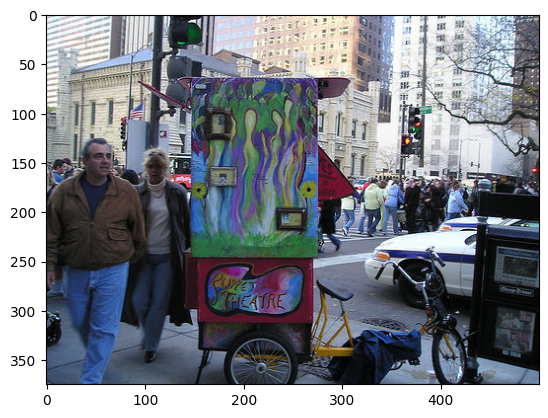

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pickle import load
from google.colab import files

# Manually set the image path for Google Colab
uploaded = files.upload()
img_path = next(iter(uploaded.keys()))

def extract_features(filename, model):
    try:
        image = Image.open(filename)
    except:
        print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
    image = image.resize((299, 299))
    image = np.array(image)
    # for images that have 4 channels, we convert them into 3 channels
    if image.shape[2] == 4:
        image = image[..., :3]
    image = np.expand_dims(image, axis=0)
    image = image / 127.5
    image = image - 1.0
    feature = model.predict(image)
    return feature

def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo, sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text

# Load the tokenizer and model
tokenizer = load(open("tokenizer.p", "rb"))
model = load_model('models2/model_0.h5')
xception_model = Xception(include_top=False, pooling="avg")

# Extract features, generate description, and display the image
photo = extract_features(img_path, xception_model)
img = Image.open(img_path)

description = generate_desc(model, tokenizer, photo, max_length)
print("\n\n")
print(description)
plt.imshow(img)
plt.show()


In [ ]:
pip install numpy Pillow matplotlib tensorflow gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.3/20.3 MB 34.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.3/66.3 kB 7.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.8/298.8 kB 23.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.7/75.7 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 4.8 MB/s eta 0:

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pickle import load
import gradio as gr

# Manually set the image path for Google Colab
def extract_features(image, model):
    image = image.resize((299, 299))
    image = np.array(image)
    if image.shape[2] == 4:
        image = image[..., :3]
    image = np.expand_dims(image, axis=0)
    image = image / 127.5
    image = image - 1.0
    feature = model.predict(image)
    return feature

def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def generate_desc(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo, sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break

    # Exclude the starting token 'start' from the generated text
    return in_text[len('start'):]


# Load the tokenizer and model
tokenizer = load(open("tokenizer.p", "rb"))
model = load_model('models1/model_9.h5')
xception_model = Xception(include_top=False, pooling="avg")

max_length = 30  # Set this to the maximum length used during training

def caption_generator(image):
    # Process the image and generate description
    img_array = image / 255.0  # Normalize pixel values to the range [0, 1]
    photo = extract_features(img_array, xception_model)
    description = generate_desc(model, tokenizer, photo, max_length)

    return {"text": description, "image": img_array}

iface = gr.Interface(fn=caption_generator, inputs="image", outputs=["text", "image"])
iface.launch()


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://58c52b7bcb9b5271f5.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [ ]:
!pip install gradio
!pip install torch
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 47.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 49.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 29.2 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.18.0
    Uninstalling huggingface-hub-0.18.0:
      Successfully uninstalled huggingface-hub-0.18.0


In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 67.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 26.9 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.18.0
    Uninstalling huggingface-hub-0.18.0:
      Successfully uninstalled huggingface-hub-0.18.0


In [ ]:
import gradio as gr
import torch
from PIL import Image
from torchvision import transforms
from transformers import AutoFeatureExtractor, AutoTokenizer, AutoModelForCausalLM

# Load your pre-trained image captioning model and tokenizer
image_model_name = "Salesforce/images/resnet-50"  # Replace with your image model
caption_model_name = "Salesforce/base"  # Replace with your captioning model
image_feature_extractor = AutoFeatureExtractor.from_pretrained(image_model_name)
caption_tokenizer = AutoTokenizer.from_pretrained(caption_model_name)
caption_model = AutoModelForCausalLM.from_pretrained(caption_model_name)

# Function to generate captions for an uploaded image
def generate_caption(image_path):
    image = Image.open(image_path)
    image = image_feature_extractor(images=image, return_tensors="pt")
    input_ids = caption_tokenizer("a photo of a", return_tensors="pt").input_ids
    input_ids = input_ids.to(caption_model.device)
    image = image.to(caption_model.device)
    caption_ids = caption_model.generate(
        input_ids, image, max_length=50, num_return_sequences=1, no_repeat_ngram_size=2
    )
    caption = caption_tokenizer.decode(caption_ids[0], skip_special_tokens=True)
    return caption

# Define the Gradio interface
image_input = gr.inputs.Image(source="upload", type="file", label="Upload an Image")
caption_output = gr.outputs.Text(label="Generated Caption")

# Create the Gradio interface
app = gr.Interface(
    fn=generate_caption,
    inputs=image_input,
    outputs=caption_output,
    title="Image Caption Generator",
    description="Generate captions for uploaded images.",
)

# Launch the Gradio interface
app.launch()

OSError: ignored

In [ ]:
!pip install streamlit


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.0/190.0 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 46.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.0 MB/s eta 0:00:00


In [ ]:
!pip install streamlit
!pip install pyngrok


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 718.7/718.7 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyngrok: filename=pyngrok-7.0.0-py3-none-any.whl size=21129 sha256=7582db598e827bef11ac0aed50d2e75dab699779ca6dfccfc4ba9113c8e0da8e
  Stored in directory: /root/.cache/pip/wheels/60/29/7b/f64332aa7e5e88fbd56d4002185ae22dcdc83b35b3d1c2cbf5
Successfully built pyngrok


In [ ]:
import streamlit as st
import numpy as np
from PIL import Image
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pickle import load

# Manually set the image path for Streamlit
uploaded_file = st.file_uploader("Choose an image...", type="jpg")

if uploaded_file is not None:
    img = Image.open(uploaded_file)

    # Load the tokenizer and model
    tokenizer = load(open("tokenizer.p", "rb"))
    model = load_model('models1/model_0.h5')
    xception_model = Xception(include_top=False, pooling="avg")

    # Extract features, generate description
    photo = extract_features(img, xception_model)
    description = generate_desc(model, tokenizer, photo, max_length)

    # Display the image and caption
    st.image(img, caption="Uploaded Image.", use_column_width=True)
    st.write("")
    st.write(f"Generated Caption: {description}")


In [ ]:
!streamlit run Final_Project.py


Usage: streamlit run [OPTIONS] TARGET [ARGS]...
Try 'streamlit run --help' for help.

Error: Invalid value: File does not exist: Final_Project.py


In [ ]:
pip install fastapi uvicorn

In [ ]:
from pathlib import Path

# Get the absolute path to the current script
current_dir = Path(__file__).parent.resolve()

# Load the tokenizer and model
tokenizer_path = current_dir / "tokenizer.p"
model_path = current_dir / "models1/model_0.h5"

tokenizer = load(open(tokenizer_path, "rb"))
model = load_model(model_path)
xception_model = Xception(include_top=False, pooling="avg")


NameError: ignored

In [ ]:
from fastapi import FastAPI, File, UploadFile, HTTPException
from fastapi.responses import HTMLResponse
from io import BytesIO
import numpy as np
from PIL import Image
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.preprocessing.sequence import pad_sequences
from pickle import load
import matplotlib.pyplot as plt

app = FastAPI()

# Load the tokenizer and model
tokenizer = load(open("tokenizer.pkl", "rb"))
model = load_model('models1/model_0.h5')
xception_model = Xception(include_top=False, pooling="avg")
max_length = 32  # Set the maximum length as per your model

def extract_features(image, model):
    image = image.resize((299, 299))
    image = np.array(image)
    if image.shape[2] == 4:
        image = image[..., :3]
    image = np.expand_dims(image, axis=0)
    image = image / 127.5
    image = image - 1.0
    feature = model.predict(image)
    return feature

def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

def generate_desc(photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo, sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text

@app.post("/uploadfile/")
async def create_upload_file(file: UploadFile = File(...)):
    try:
        contents = await file.read()
        image = Image.open(BytesIO(contents))
        photo = extract_features(image, xception_model)
        description = generate_desc(photo, max_length)

        # Display the generated caption and the image
        response_html = f"""
        <h1>Generated Caption:</h1>
        <p>{description}</p>
        <h1>Uploaded Image:</h1>
        <img src="data:image/png;base64,{contents.decode("utf-8")}" alt="Uploaded Image">
        """
        return HTMLResponse(content=response_html, status_code=200)
    except Exception as e:
        raise HTTPException(status_code=500, detail=f"Error processing image: {str(e)}")


FileNotFoundError: ignored

In [ ]:
#mlflow

In [ ]:
!wget -q -O - ipv4.icanhazip.com

34.125.3.161


In [ ]:
!streamlit run utils.py & npx localtunnel --port 8501

Usage: streamlit run [OPTIONS] TARGET [ARGS]...
Try 'streamlit run --help' for help.

Error: Invalid value: File does not exist: utils.py
npx: installed 22 in 6.216s
your url is: https://early-kings-work.loca.lt
^C


In [ ]:
import pickle
import streamlit as st
from PIL import Image
import io
import numpy as np

# Load the pre-trained model from a pickle file
with open('tokenizer.p', 'rb') as model_file:
    model = pickle.load(model_file)

def generate_caption(image):
    # Replace this with your model's caption generation logic
    # This function should take an image as input and return the generated caption
    # Example:
    caption = "A cat is sitting on a table."
    return caption

def main():
    st.title("Image Caption Generation")
    st.write("Upload an image, and the app will generate a caption for it.")

    uploaded_image = st.file_uploader("Choose an image...", type=["jpg", "png", "jpeg"])

    if uploaded_image is not None:
        image = Image.open(uploaded_image)
        st.image(image, caption="Uploaded Image", use_column_width=True)

        if st.button("Generate Caption"):
            # Preprocess the image and generate a caption
            image_array = np.array(image)
            caption = generate_caption(image_array)
            st.write("Generated Caption:", caption)

if __name__ == "_main_":
    main()

In [ ]:
pip install streamlit -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.0/190.0 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.7 MB/s eta 0:00:00


In [ ]:
!wget -q -O - ipv4.icanhazip.com

34.67.131.109


In [ ]:
!streamlit run app.py & npx localtunnel --port 8501

[#######...........] / extract:localtunnel: verb lock using /root/.npm/_locks/s

npx: installed 22 in 4.167s
your url is: https://eager-years-like.loca.lt

  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://34.67.131.109:8501

2023-10-13 04:31:33.162783: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
  Stopping...
^C


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.13.0


In [ ]:
pip install tensorflow-gpu==2.13.0

ERROR: Could not find a version that satisfies the requirement tensorflow-gpu==2.13.0 (from versions: 2.8.0rc0, 2.8.0rc1, 2.8.0, 2.8.1, 2.8.2, 2.8.3, 2.8.4, 2.9.0rc0, 2.9.0rc1, 2.9.0rc2, 2.9.0, 2.9.1, 2.9.2, 2.9.3, 2.10.0rc0, 2.10.0rc1, 2.10.0rc2, 2.10.0rc3, 2.10.0, 2.10.1, 2.11.0rc0, 2.11.0rc1, 2.11.0rc2, 2.11.0, 2.12.0)
ERROR: No matching distribution found for tensorflow-gpu==2.13.0


In [ ]:
!pip install tensorflow-tensorrt

ERROR: Could not find a version that satisfies the requirement tensorflow-tensorrt (from versions: none)
ERROR: No matching distribution found for tensorflow-tensorrt


In [ ]:
!streamlit run app.py &




  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://34.67.131.109:8501

  Stopping...


In [ ]:
import time
time.sleep(10)

In [ ]:
!wget -q -O - ipv4.icanhazip.com

34.67.131.109


In [ ]:
!streamlit run app.py & npx localtunnel --port 8501

[..................] \ fetchMetadata: sill resolveWithNewModule localtunnel@2.0


  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://34.67.131.109:8501

npx: installed 22 in 2.914s
your url is: https://afraid-animals-accept.loca.lt
2023-10-13 08:45:53.162241: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
1/1 [==============================] - 1s 1s/step
